# Metoda CP
## Opis danych
Dane pochodzą z bazy o nazwie TUH Abnormal EEG Corpus (https://isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v2.0.0/). Są to zapisy sygnału EEG z jednego szpitala sklasyfikowane jako prawidłowe lub nieprawidłowe.

## Podstawowe informacje ułatwiające dalsze zrozumienie:
Do badania użyto standardowego układu elektrod 10-20, wygląda on następująco:

<p><IMG src="img/10-20.png" width=500></p>

Do każdego sygnału EEG jest załączony opis lekarza, który nie zawsze używa konkretnych nazw elektrod, tylko bardziej ogólne określenia.

* Parzyste numery elektrod są po prawej stronie, nieparzyste - po lewej
* Geneza literek w nazwach: pre-frontal (Fp), frontal (F), temporal (T), parietal (P), occipital (O), central (C)
* Zwolnienia w obszarach mózgu, K kompleksy - niskie częstotliwości
* Vertex, sharp waves - wyższe częstotliwości
* Wrzeciona snu (spindles) 12-16 Hz
    
## Wybór cech
Lekarze oceniali sygnały EEG używając jedynie oczu i linijek - skupiali się więc na mocy danych częstotliwości w danych kanałach. Aby móc porównywać moje wyjaśnienia z ich opisami, wybrałam te same cechy. Dla każdego kanału obliczyłam moc sygnału w następujących pasmach częstotliwości:

* 0-2 Hz (delta)
* 1-3 Hz (delta)
* 2-4 Hz (delta)
* 3-6 Hz (theta)
* 4-8 Hz (theta)
* 6-10 Hz (alfa)
* 8-13 Hz (alfa)
* 10-15 Hz (beta)
* 13-18 Hz (beta)
* 15-21 Hz (beta)
* 18-24 Hz (beta)
* 21-27 Hz (beta)
* 24-30 Hz (gamma)
* 27-39 Hz (gamma)
* 30-49 Hz (gamma)
Uzyskałam w ten sposób 15x21=315 cech. Nie stosowałam żadnych redukcji cech, ponieważ chciałam uzyskać pełen obraz dla wszystkich cech.
    
## Drzewo decyzyjne

### Wyniki modelu na zbiorze ewaluacyjnym
* ACC - 0.84

## Sieć konwolucyjna   
Jako drugi model wybrałam prostą sieć konwolucyjną, która na wejściu otrzymuje macierz tych samych danych, ale o kształcie (liczba_pasm x liczba_kanałów).
### Wyniki modelu na zbiorze ewaluacyjnym:
* ACC - 0.77
    
## SVC
Trzeci model to model SVC który na wejściu otrzymuje dane w tej samej postaci co sieć konwolucyjna, czyli (liczba_pasm x liczba_kanałów).
### Wyniki modelu na zbiorze ewaluacyjnym:
* ACC - 0.81
    
## Metodologia
    
Dla każdego z modeli zbadałam istotność cech na 4 różne sposoby:
* Tradycyjna permutacja jednej cechy i porównywanie ACC przed i po 
* Zastosowanie schematu jak w metodzie SHAP, tylko że zamiast podstawiania wartości od konkretnego pacjenta, permutuję cechy
* Tradycyjna permutacja całego kanału na raz oraz całego pasma na raz
* Permutacja ze schematem SHAP całego kanału na raz oraz całego pasma na raz
    
Dodatkowo aby łatwiej się porównywało pierwsze dwie metody z dwoma ostatnimi, zsumowałam wartości z pierwszych dwoch metod (każda osobno) po kanałach lub po wszystkich pasmach.
    
Ponieważ permutację powtórzyłam 50 razy dla każdej metody i wyniki uśredniałam, w ten sam sposób przedstawiłam również odchylenie standardowe średniej dla uśrednionych wartości.

## Wyniki
    
### Random Forest
<IMG src="img/rf_mean.png" width=500>
<IMG src="img/rf_std.png" width=500>
    
### SVC
<IMG src="img/svc_mean.png" width=500>
<IMG src="img/svc_std.png" width=500>
    
### Sieć konwolucyjna
<IMG src="img/conv_mean.png" width=500>
<IMG src="img/conv_std.png" width=500>

## Dyskusja
    
Moim zdaniem, dużo lepiej wyglądają wyniki dla metod SHAP. Nie do końca rozumiem czemu często dla tradycyjnej permutacji ACC maleje po spermutowaniu. Tak jak już wcześniej mówiłam, gdy ktoś jest chory to będzie to widać w wielu różnych częściach mózgu w wielu częstotliwościach, dlatego też spodziewałam się lepszych wyników dla schematu SHAP gdzie po prostu była szansa zaszumić więcej chorych obszarów na raz. 
    
Ciekawe jest to że różne modele mają swoje najważniejsze cechy w różnych pasmach częstotliwości (SVC głównie delcie, RF alfa/delta, Conv  w alfie), ale wszystkie skupiają się głównie na obszarach temporalnych.
    
Co do odchyleń standardowych to wszędzie widać ten sam efekt - największe jest w tych ważnych obszarach, ale jest wystarczająco małe aby z czystym sumieniem brać pod uwagę powyższe wyniki.
    
Podsumowując, wychodzi na to że najbardziej wrażliwe na choroby są obszary temporalne w delcie i alfie, co było potwierdzane wielokrotnie przy wyjaśnianiu poszczególnych przypadków w poprzednich pracach domowych.

# Appendix 

In [70]:
import os
import pandas as pd
import time
from pathlib import Path
import numpy as np
import dalex as dx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from einops import rearrange
from skimage import color
from sklearn.svm import SVC
from joblib import Parallel, delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score

In [71]:
ch_names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 
            'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'FZ', 'CZ', 'PZ']

BAND_LIMITS = np.array([[ 0,  2, 'delta'],
       [ 1,  3, 'delta'],
       [ 2,  4, 'delta'],
       [ 3,  6, 'theta'],
       [ 4,  8, 'theta'],
       [ 6, 10, 'alfa'],
       [ 8, 13, 'alfa'],
       [10, 15, 'beta'],
       [13, 18, 'beta'],
       [15, 21, 'beta'],
       [18, 24, 'beta'],
       [21, 27, 'beta'],
       [24, 30, 'gamma'],
       [27, 39, 'gamma'],
       [30, 49, 'gamma']])

In [72]:
X_train = pd.read_csv('data/X_train.csv')
Y_train = np.load('data/Y_train.npy')
X_eval = pd.read_csv('data/X_eval.csv')
Y_eval = np.load('data/Y_eval.npy')
cols = np.array(X_eval.columns)

# Model Random Forest

In [73]:
clf_eval_rf = RandomForestClassifier(n_estimators=1600, max_depth=90, max_features="sqrt", min_samples_split=2, random_state=4, 
                             criterion='entropy', n_jobs=20)
clf_eval_rf.fit(X_train, Y_train)
preds = clf_eval_rf.predict(X_eval)
probs = clf_eval_rf.predict_proba(X_eval)
acc_rf = accuracy_score(Y_eval, preds)
mcc = matthews_corrcoef(Y_eval, preds)
tn, fp, fn, tp = confusion_matrix(Y_eval, preds).ravel()
spec = tn / (tn+fp)
sens = tp / (tp + fp)
print(acc_rf, mcc, spec, sens)

0.8369565217391305 0.671317113342619 0.8866666666666667 0.8521739130434782


# Model sieci konwolucyjnej

In [74]:
def make_matrix(X):
    X_net = np.zeros((len(X), 1, len(BAND_LIMITS), len(ch_names)))
    for idx, sub in enumerate(X):
        for idx_ch, ch in enumerate(ch_names):
            for idx_b, [l, h, n] in enumerate(BAND_LIMITS):
                name = f'ch_{ch}_{l}-{h} Hz ({n})'
                X_net[idx, 0, idx_b, idx_ch] = sub[name == cols]
        
    return X_net.astype('float32')

X_eval_mat = make_matrix(np.array(X_eval))
X_train_mat = make_matrix(np.array(X_train))

In [75]:
class Shallow(nn.Module):
    
    def __init__(self, f1, f2):
        
        super().__init__()
        
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        
        self.conv1 = nn.Conv2d(1, f1, (3, 4))
        
        self.conv2 = nn.Conv2d(f1, f2, (3, 4))
        
        self.avr = nn.AvgPool2d((3, 3), stride=(2, 2))
        
        self.lin = nn.Linear(int(350 * f2/10), 1)

    def forward(self, x):
        #print(x.shape)
        z = self.conv1(x)
        #print(z.shape)
        #print(z.shape)
        z = self.conv2(z)
        #print(z.shape)
        z = torch.square(z)
        #print(z.shape)
        z = self.avr(z)
        #print(z.shape)
        z = torch.log(z)
        z = rearrange(z, 'b c d e -> b (c d e)')
        z = self.lin(z)
        #print(z.shape)
        
        z = torch.sigmoid(z)
        
        return z
    
    def predict(self, X):
        
        return get_pred(self.predict_proba(X))
    
    def predict_proba(self, X):
        
        #print(np.array(X).shape)
        X = make_matrix(np.array(X))
        
        return self(torch.from_numpy(X)).cpu().detach().numpy().copy()[:, 0]

In [76]:
def evaluate(Net, X_eval, probs, MCC, Loss, epoch, trloss, t0):

    Net.eval()
    j = 0
    for i in range(len(X_eval_mat) // batch_size):
        X = torch.from_numpy(X_eval_mat[i * batch_size : min((i + 1) * batch_size, len(Y_eval) - 1)])

        X = X.to(device)

        nt = len(X)
        
        out = Net(X)
        probs[j:j+nt] = out.cpu().detach().numpy().copy()[:, 0]
        j += nt

    preds = get_pred(probs)
    acc = accuracy_score(Y_eval, preds)

    ACC[epoch-1] = acc
    Loss[epoch-1] = trloss
    print(f"Epoch {epoch}, time {(time.time() - t0) / 60:.2f} min, ACC {acc:.2f}, loss {trloss:.2f}")

def get_pred(probs):

    if np.sum(np.isnan(probs)) > 0:
        raise Warning("Nan values in probs!")
    else:
        return (probs.flatten() > 0.5) * 1

epochs = 16
batch_size = 64
probs = np.zeros((len(X_eval)))
ACC = np.zeros((epochs))
Loss = ACC.copy()
device = torch.device("cuda:0" if not torch.cuda.is_available() else "cpu")

LOSS = nn.BCELoss()
t0_mod = time.time()
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

def run_net(f1, f2):
    Net = Shallow(f1, f2)
    Net.to(device)
    optimizer = torch.optim.AdamW(Net.parameters())
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    for epoch in range(1, epochs + 1):
        t0_ep = time.time()

        Net.train()
        trloss = 0
        for i in range(len(X_train_mat) // batch_size):
            X = torch.from_numpy(X_train_mat[i * batch_size : min((i + 1) * batch_size, len(Y_train) - 1)])
            y = torch.from_numpy(np.array([Y_train[i * batch_size : min((i + 1) * batch_size, len(Y_train) - 1)]]).T.astype('float32'))

            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            out = Net(X)

            loss = LOSS(out, y)

            loss.backward()
            optimizer.step()
            trloss += loss.data.item() * len(X)

        trloss /= len(X_train)

        evaluate(Net, X_eval, probs, ACC, Loss, epoch, trloss, t0_ep)

    print(f"Finished, time {(time.time() - t0_mod) / 60:.2f} min\n")
    return Net

Net = run_net(7, 12)
preds = get_pred(probs)
acc_net = ACC[-1]

Epoch 1, time 0.00 min, ACC 0.71, loss 0.72
Epoch 2, time 0.00 min, ACC 0.72, loss 0.60
Epoch 3, time 0.00 min, ACC 0.74, loss 0.54
Epoch 4, time 0.00 min, ACC 0.73, loss 0.52
Epoch 5, time 0.00 min, ACC 0.73, loss 0.52
Epoch 6, time 0.00 min, ACC 0.74, loss 0.51
Epoch 7, time 0.00 min, ACC 0.75, loss 0.50
Epoch 8, time 0.00 min, ACC 0.75, loss 0.50
Epoch 9, time 0.00 min, ACC 0.75, loss 0.50
Epoch 10, time 0.00 min, ACC 0.75, loss 0.50
Epoch 11, time 0.00 min, ACC 0.75, loss 0.50
Epoch 12, time 0.00 min, ACC 0.76, loss 0.50
Epoch 13, time 0.00 min, ACC 0.76, loss 0.49
Epoch 14, time 0.00 min, ACC 0.76, loss 0.49
Epoch 15, time 0.00 min, ACC 0.76, loss 0.49
Epoch 16, time 0.00 min, ACC 0.77, loss 0.49
Finished, time 0.03 min



# SVC

In [77]:
clf_eval_svc = SVC(kernel="rbf", C=10, probability=True, gamma="auto")
clf_eval_svc.fit(X_train, Y_train)
preds = clf_eval_svc.predict(X_eval)
acc_svc = accuracy_score(Y_eval, preds)
acc_svc

0.8079710144927537

# Permutacje:

Funkcja dla tradycyjnej permutacji:

In [78]:
def trad_perm(n_perm, name, clf, acc):
    n_feat = len(cols)
    l = 0
    T = np.zeros((n_feat, n_perm))
    for idx_f, f in enumerate(cols):
        for idx_p in range(n_perm):
            t0 = time.time()
            df = X_eval.copy()
            df[f] = np.random.permutation(df[f])
            preds2 = clf.predict(df)
            T[idx_f, idx_p] = acc - accuracy_score(Y_eval, preds2)
            l += 1
            print(f"{l} z {n_feat*n_perm}, {(time.time() - t0) / 60}")

    np.save(f'results/{name}_trad.npy', T)

Funkcja dla shapowej permutacji:

In [79]:
def shap_perm(n_perm, name, clf):
    n_feat = len(cols)

    T = np.zeros((n_feat, n_perm))
    shuff_cols = cols.copy()

    l = 0
    for idx_f, f in enumerate(cols):
        for idx_p in range(n_perm):

            t0 = time.time()

            df = X_eval.copy()
            np.random.shuffle(shuff_cols)
            idx_sh_f = np.argwhere(shuff_cols == f)[0, 0]
            cols_bf = shuff_cols[:idx_sh_f]
            for c in cols_bf:
                df[c] = np.random.permutation(df[c])

            preds_bf = clf.predict(df)
            acc_bf = accuracy_score(Y_eval, preds_bf)


            df[f] = np.random.permutation(df[f])

            preds_af = clf.predict(df)
            acc_af = accuracy_score(Y_eval, preds_af)

            T[idx_f, idx_p] = acc_bf - acc_af

            l += 1
            print(f"{l} z {n_feat*n_perm}, {(time.time() - t0) / 60}, {acc_bf}, {acc_af}, {acc_bf - acc_af}")

    np.save(f'results/{name}_shap.npy', T)

Permutowanie całych kanałów na raz:

In [80]:
def trad_perm_chan(n_perm, name, clf, acc):
    n_feat = len(ch_names)
    c = 0
    T = np.zeros((n_feat, n_perm))
    for idx_ch, ch in enumerate(ch_names):
        for idx_p in range(n_perm):
            t0 = time.time()
            df = X_eval.copy()
            for idx_f, [l, h, n] in enumerate(BAND_LIMITS):
                f = f'ch_{ch}_{l}-{h} Hz ({n})'
                df[f] = np.random.permutation(df[f])
            preds2 = clf.predict(df)
            T[idx_f, idx_p] = acc - accuracy_score(Y_eval, preds2)
            c += 1
            print(f"{c} z {n_feat*n_perm}, {(time.time() - t0) / 60}")

    np.save(f'results/{name}_trad_chan.npy', T)
    
    
    
def shap_perm_chan(n_perm, name, clf):
    n_feat = len(ch_names)

    T = np.zeros((n_feat, n_perm))
    shuff_chans = np.array(ch_names, dtype='str').copy()

    c = 0
    for idx_ch, ch in enumerate(ch_names):
        for idx_p in range(n_perm):

            t0 = time.time()

            df = X_eval.copy()
            np.random.shuffle(shuff_chans)
            idx_sh = np.argwhere(shuff_chans == ch)[0, 0]
            chans_bf = shuff_chans[:idx_sh]
            for chans in chans_bf:
                for idx_f, [l, h, n] in enumerate(BAND_LIMITS):
                    f = f'ch_{chans}_{l}-{h} Hz ({n})'
                    df[f] = np.random.permutation(df[f])

            preds_bf = clf.predict(df)
            acc_bf = accuracy_score(Y_eval, preds_bf)


            for idx_f, [l, h, n] in enumerate(BAND_LIMITS):
                f = f'ch_{ch}_{l}-{h} Hz ({n})'
                df[f] = np.random.permutation(df[f])

            preds_af = clf.predict(df)
            acc_af = accuracy_score(Y_eval, preds_af)

            T[idx_ch, idx_p] = acc_bf - acc_af

            c += 1
            print(f"{c} z {n_feat*n_perm}, {(time.time() - t0) / 60}, {acc_bf}, {acc_af}, {acc_bf - acc_af}")

    np.save(f'results/{name}_shap_chan.npy', T)

Permutowanie całych częstotliwości na raz:

In [81]:
def trad_perm_freq(n_perm, name, clf, acc):
    n_feat = len(BAND_LIMITS)
    c = 0
    T = np.zeros((n_feat, n_perm))
    for idx_f, [l, h, n] in enumerate(BAND_LIMITS):
        for idx_p in range(n_perm):
            t0 = time.time()
            df = X_eval.copy()
            for idx_ch, ch in enumerate(ch_names):
                f = f'ch_{ch}_{l}-{h} Hz ({n})'
                df[f] = np.random.permutation(df[f])
            preds2 = clf.predict(df)
            T[idx_f, idx_p] = acc - accuracy_score(Y_eval, preds2)
            c += 1
            print(f"{c} z {n_feat*n_perm}, {(time.time() - t0) / 60}")

    np.save(f'results/{name}_trad_freq.npy', T)
    
def shap_perm_freq(n_perm, name, clf):
    n_feat = len(BAND_LIMITS)

    T = np.zeros((n_feat, n_perm))
    shuff_freqs = np.array(BAND_LIMITS, dtype='str').copy()

    c = 0
    for idx_f, [l, h, n] in enumerate(BAND_LIMITS):
        for idx_p in range(n_perm):

            t0 = time.time()

            df = X_eval.copy()
            np.random.shuffle(shuff_freqs)
            idx_sh = np.argwhere(shuff_freqs == [l, h, n])[0, 0]
            freqs_bf = shuff_freqs[:idx_sh]
            for idx_f2, [l2, h2, n2] in enumerate(freqs_bf):
                for idx_ch, chans in enumerate(ch_names):
                    f = f'ch_{chans}_{l2}-{h2} Hz ({n2})'
                    df[f] = np.random.permutation(df[f])

            preds_bf = clf.predict(df)
            acc_bf = accuracy_score(Y_eval, preds_bf)


            for idx_ch, chans in enumerate(ch_names):
                f = f'ch_{chans}_{l}-{h} Hz ({n})'
                df[f] = np.random.permutation(df[f])

            preds_af = clf.predict(df)
            acc_af = accuracy_score(Y_eval, preds_af)

            T[idx_f, idx_p] = acc_bf - acc_af

            c += 1
            print(f"{c} z {n_feat*n_perm}, {(time.time() - t0) / 60}, {acc_bf}, {acc_af}, {acc_bf - acc_af}")

    np.save(f'results/{name}_shap_freq.npy', T)

Permutowanie, to się długo robi:

In [93]:
P = {'conv': [Net, acc_net], 'rf': [clf_eval_rf, acc_rf], 'svc': [clf_eval_svc, acc_svc]}
n_perm = 50

Parallel(n_jobs=3)(
            delayed(shap_perm) (n_perm, name, clf) for name, [clf, acc] in P.items())

Parallel(n_jobs=3)(
            delayed(trad_perm) (n_perm, name, clf, acc) for name, [clf, acc] in P.items())

Parallel(n_jobs=3)(
            delayed(trad_perm_freq) (n_perm, name, clf, acc) for name, [clf, acc] in P.items())

Parallel(n_jobs=3)(
            delayed(trad_perm_chan) (n_perm, name, clf, acc) for name, [clf, acc] in P.items())

Parallel(n_jobs=3)(
            delayed(shap_perm_freq) (n_perm, name, clf) for name, [clf, acc] in P.items())
Parallel(n_jobs=3)(
            delayed(shap_perm_chan) (n_perm, name, clf) for name, [clf, acc] in P.items())

KeyboardInterrupt: 

Rysunki jako mapy cieplne:

In [96]:
def plot_matrix(X):
    sc = 1
    res_path = 'img/'
    if np.sum(X < 0) == 0:
        vmin = np.min(X)
        vmax = np.max(X)
        cmap = 'Reds'
    else:
        clim = np.max(np.abs(X))
        vmin = -clim
        vmax = clim
        cmap = 'RdBu_r'
    
    #plt.figure(figsize=(sc*12, sc*7.5))
    plt.imshow(X, cmap = cmap, vmin = vmin, vmax = vmax)
    plt.xticks(np.arange(0, len(ch_names)), ch_names, fontsize=12*sc)
    plt.yticks(np.arange(0, len(BAND_LIMITS)), (f'{int(l)}-{int(h)} Hz ({n})' for l, h, n in BAND_LIMITS), fontsize=12*sc)
    plt.xlabel("Kanały", fontsize=15*sc)
    plt.ylabel("Pasma mocy", fontsize=15*sc)
    plt.colorbar(fraction=0.03, pad=0.01)
    #plt.savefig(res_path + f'{name}.png')
    #plt.show()
    
def plot_row(X, name):
    sc = 1
    res_path = 'img/'
    if np.sum(X < 0) == 0:
        vmin = np.min(X)
        vmax = np.max(X)
        cmap = 'Reds'
    else:
        clim = np.max(np.abs(X))
        vmin = -clim
        vmax = clim
        cmap = 'RdBu_r'
    
    
    X = X.reshape(1, len(X))
    #plt.figure(figsize=(sc*12, sc*7.5))
    plt.imshow(X, cmap = cmap, vmin = vmin, vmax = vmax)
    if 'chan' == name:
        plt.xticks(np.arange(0, len(ch_names)), ch_names, fontsize=12*sc)
        plt.xlabel("Kanały", fontsize=15*sc)
    else:
        plt.xticks(np.arange(0, len(BAND_LIMITS)), (f'{int(l)}-{int(h)} Hz ({n})' for l, h, n in BAND_LIMITS), fontsize=12*sc, rotation=90)
        plt.xlabel("Pasma mocy", fontsize=15*sc)
        
    plt.yticks([])
    plt.colorbar(fraction=0.03, pad=0.01)
    #plt.savefig(res_path + f'{name}.png')
    #plt.show()
    
def plot_subplot(model_name, val, fun):
    
    sc = 1
    plt.figure(figsize=(20*sc, 40*sc))
    plt.suptitle(f"{model_name}, {val} values", fontsize=50*sc)
    
    plt.subplot(5, 2, 1)
    plt.title("Traditional permutation")
    trad = np.load(f'results2/{model_name}_trad.npy')
    trad = fun(trad, axis=1)
    trad = make_matrix(trad[np.newaxis])[0, 0]
    plot_matrix(trad)
    
    plt.subplot(5, 2, 2)
    plt.title("SHAP permutation")
    shap = np.load(f'results2/{model_name}_shap.npy')
    shap = fun(shap, axis=1)
    shap = make_matrix(shap[np.newaxis])[0, 0]
    plot_matrix(shap)
    
    
    
    plt.subplot(5, 2, 3)
    plt.title("Traditional channel permutation")
    tchp = np.load(f'results2/{model_name}_trad_chan.npy')
    plot_row(fun(tchp, axis=1)/tchp.shape[1], 'chan')
    
    plt.subplot(5, 2, 4)
    plt.title("Traditional bands permutation")
    tbp = np.load(f'results2/{model_name}_trad_freq.npy')
    plot_row(fun(tbp, axis=1)/tbp.shape[1], 'freq')
    
    
    
    plt.subplot(5, 2, 5)
    plt.title("SHAP channel permutation")
    schp = np.load(f'results2/{model_name}_shap_chan.npy')
    plot_row(fun(schp, axis=1)/schp.shape[1], 'chan')
    
    plt.subplot(5, 2, 6)
    plt.title("SHAP bands permutation")
    sbp = np.load(f'results2/{model_name}_shap_freq.npy')
    plot_row(fun(sbp, axis=1)/sbp.shape[1], 'freq')
    
    
    
    plt.subplot(5, 2, 7)
    plt.title(f"Sum channel SHAP permutation")
    plot_row(fun(shap, axis=0)/shap.shape[1], 'chan')
    
    plt.subplot(5, 2, 8)
    plt.title(f"Sum bands SHAP permutation")
    plot_row(fun(shap, axis=1)/shap.shape[1], 'freq')
    
    
    
    plt.subplot(5, 2, 9)
    plt.title(f"Sum channel traditional permutation")
    plot_row(fun(trad, axis=0)/shap.shape[1], 'chan')
    
    plt.subplot(5, 2, 10)
    plt.title(f"Sum bands traditional permutation")
    plot_row(fun(trad, axis=1)/shap.shape[1], 'freq')
    
    plt.tight_layout()
    plt.savefig(f'img/{model_name}_{val}')
    plt.show()
    

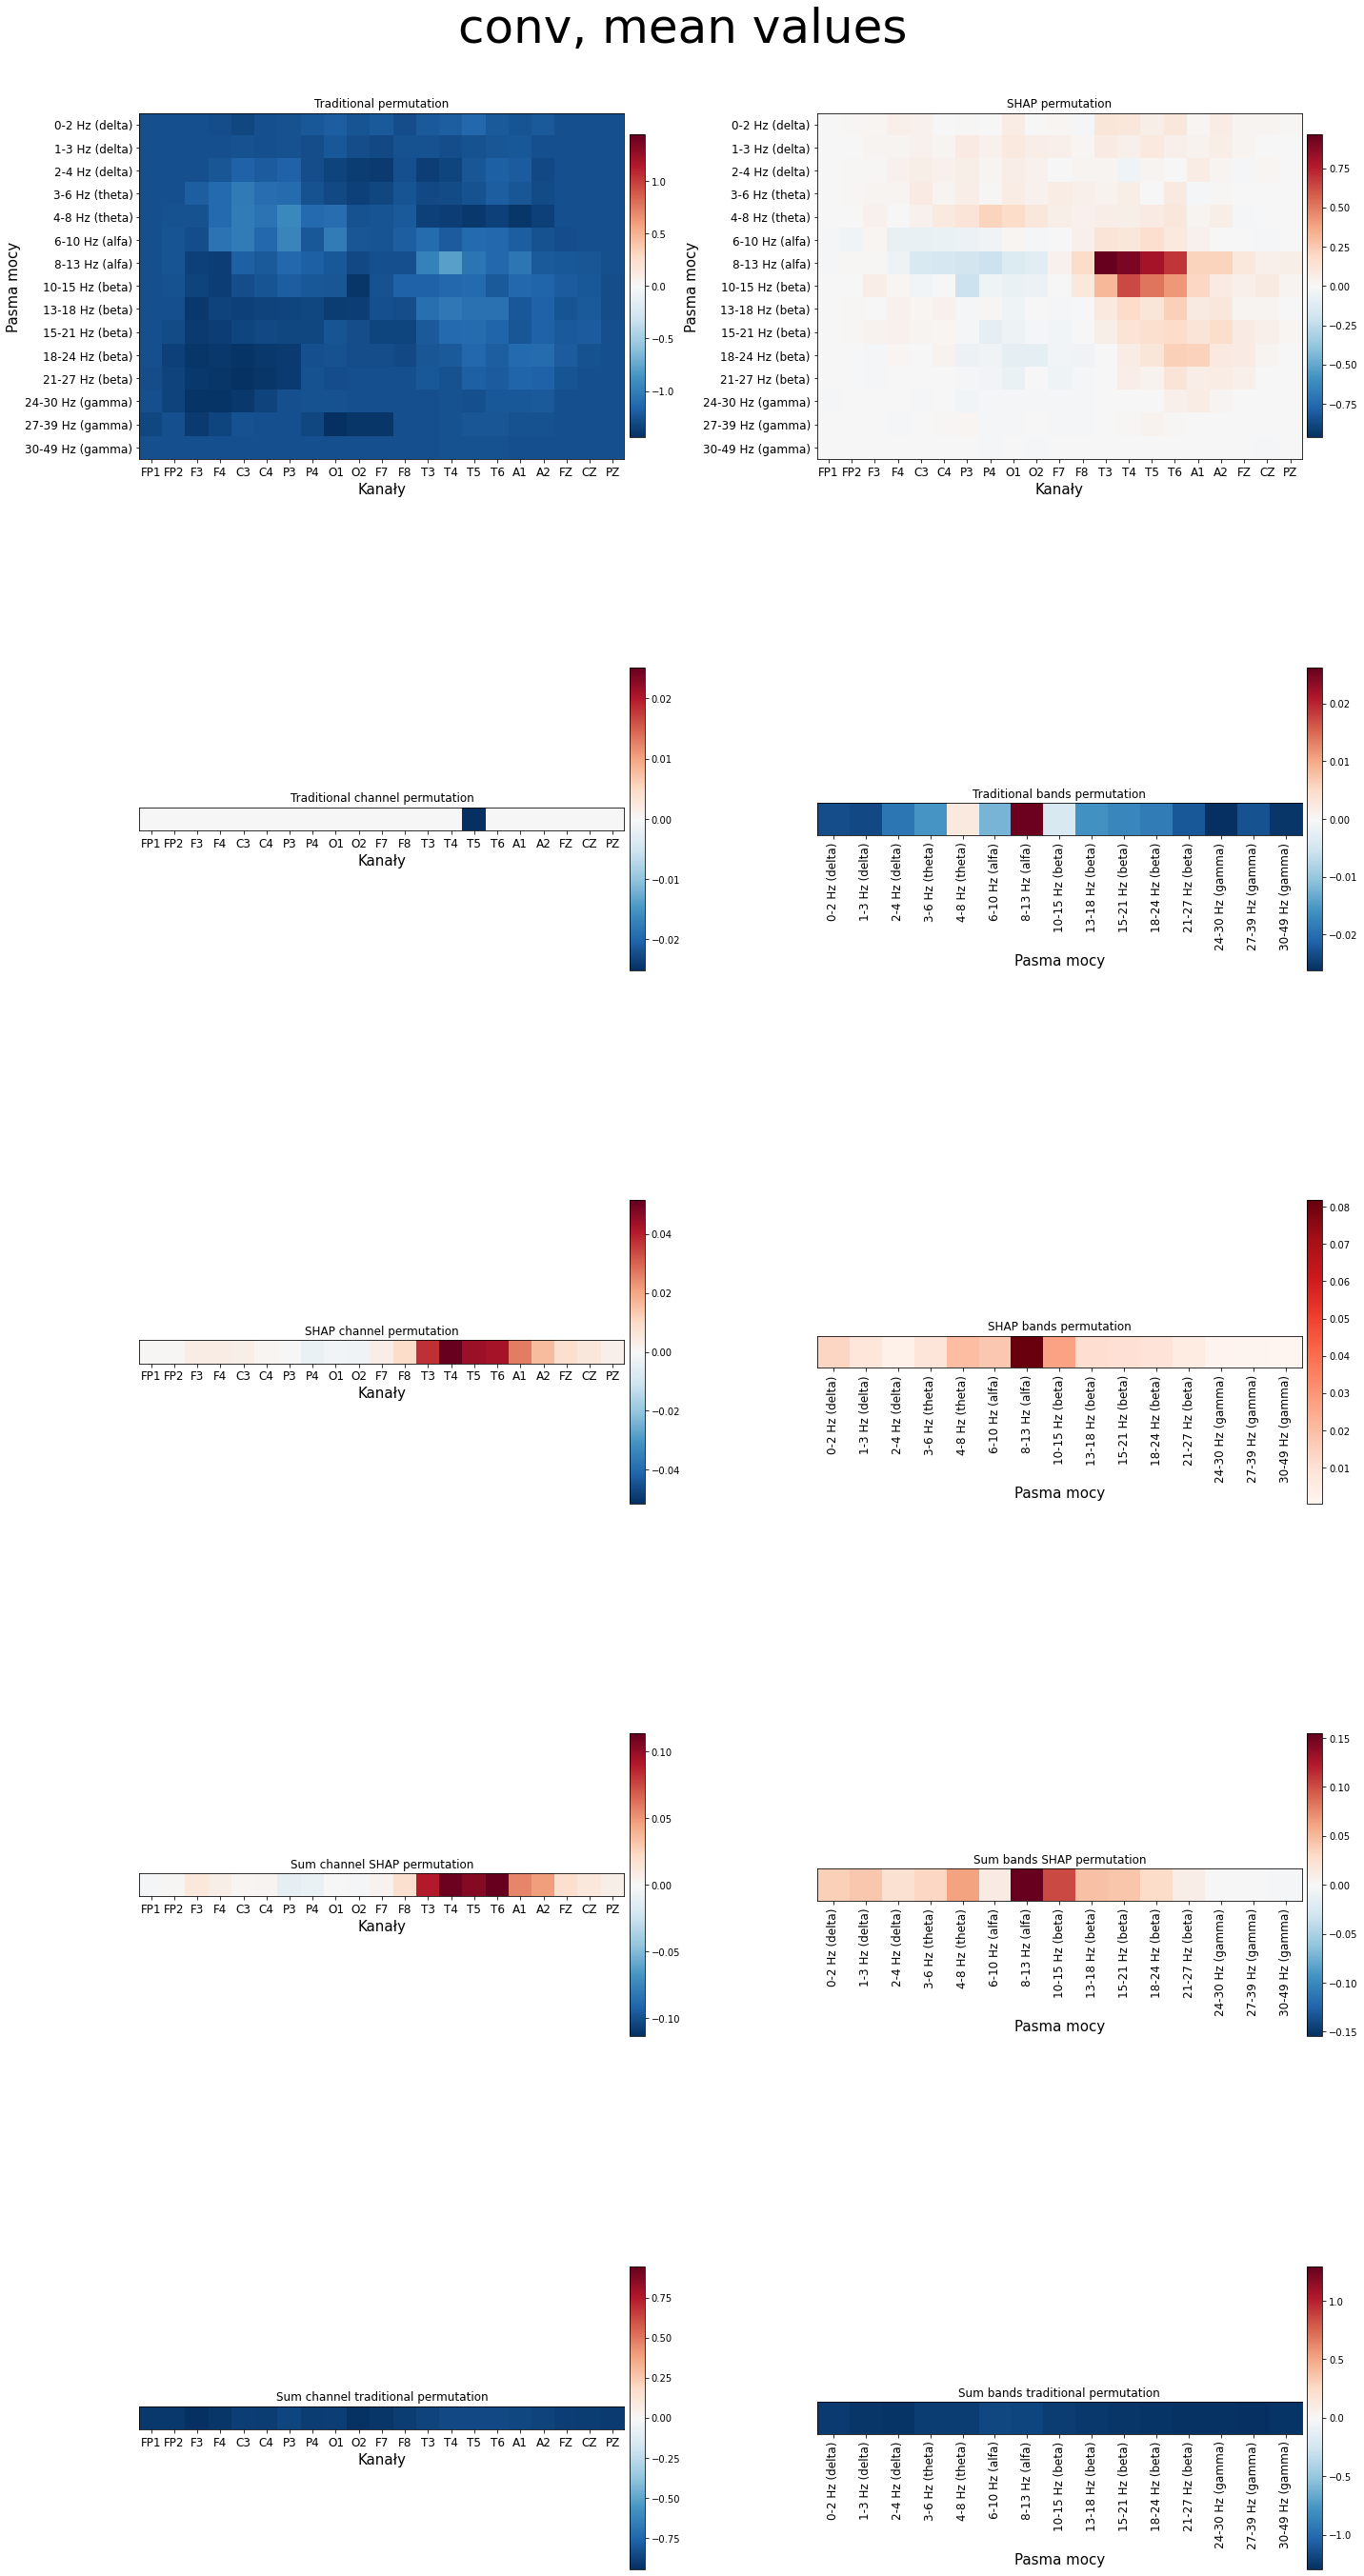

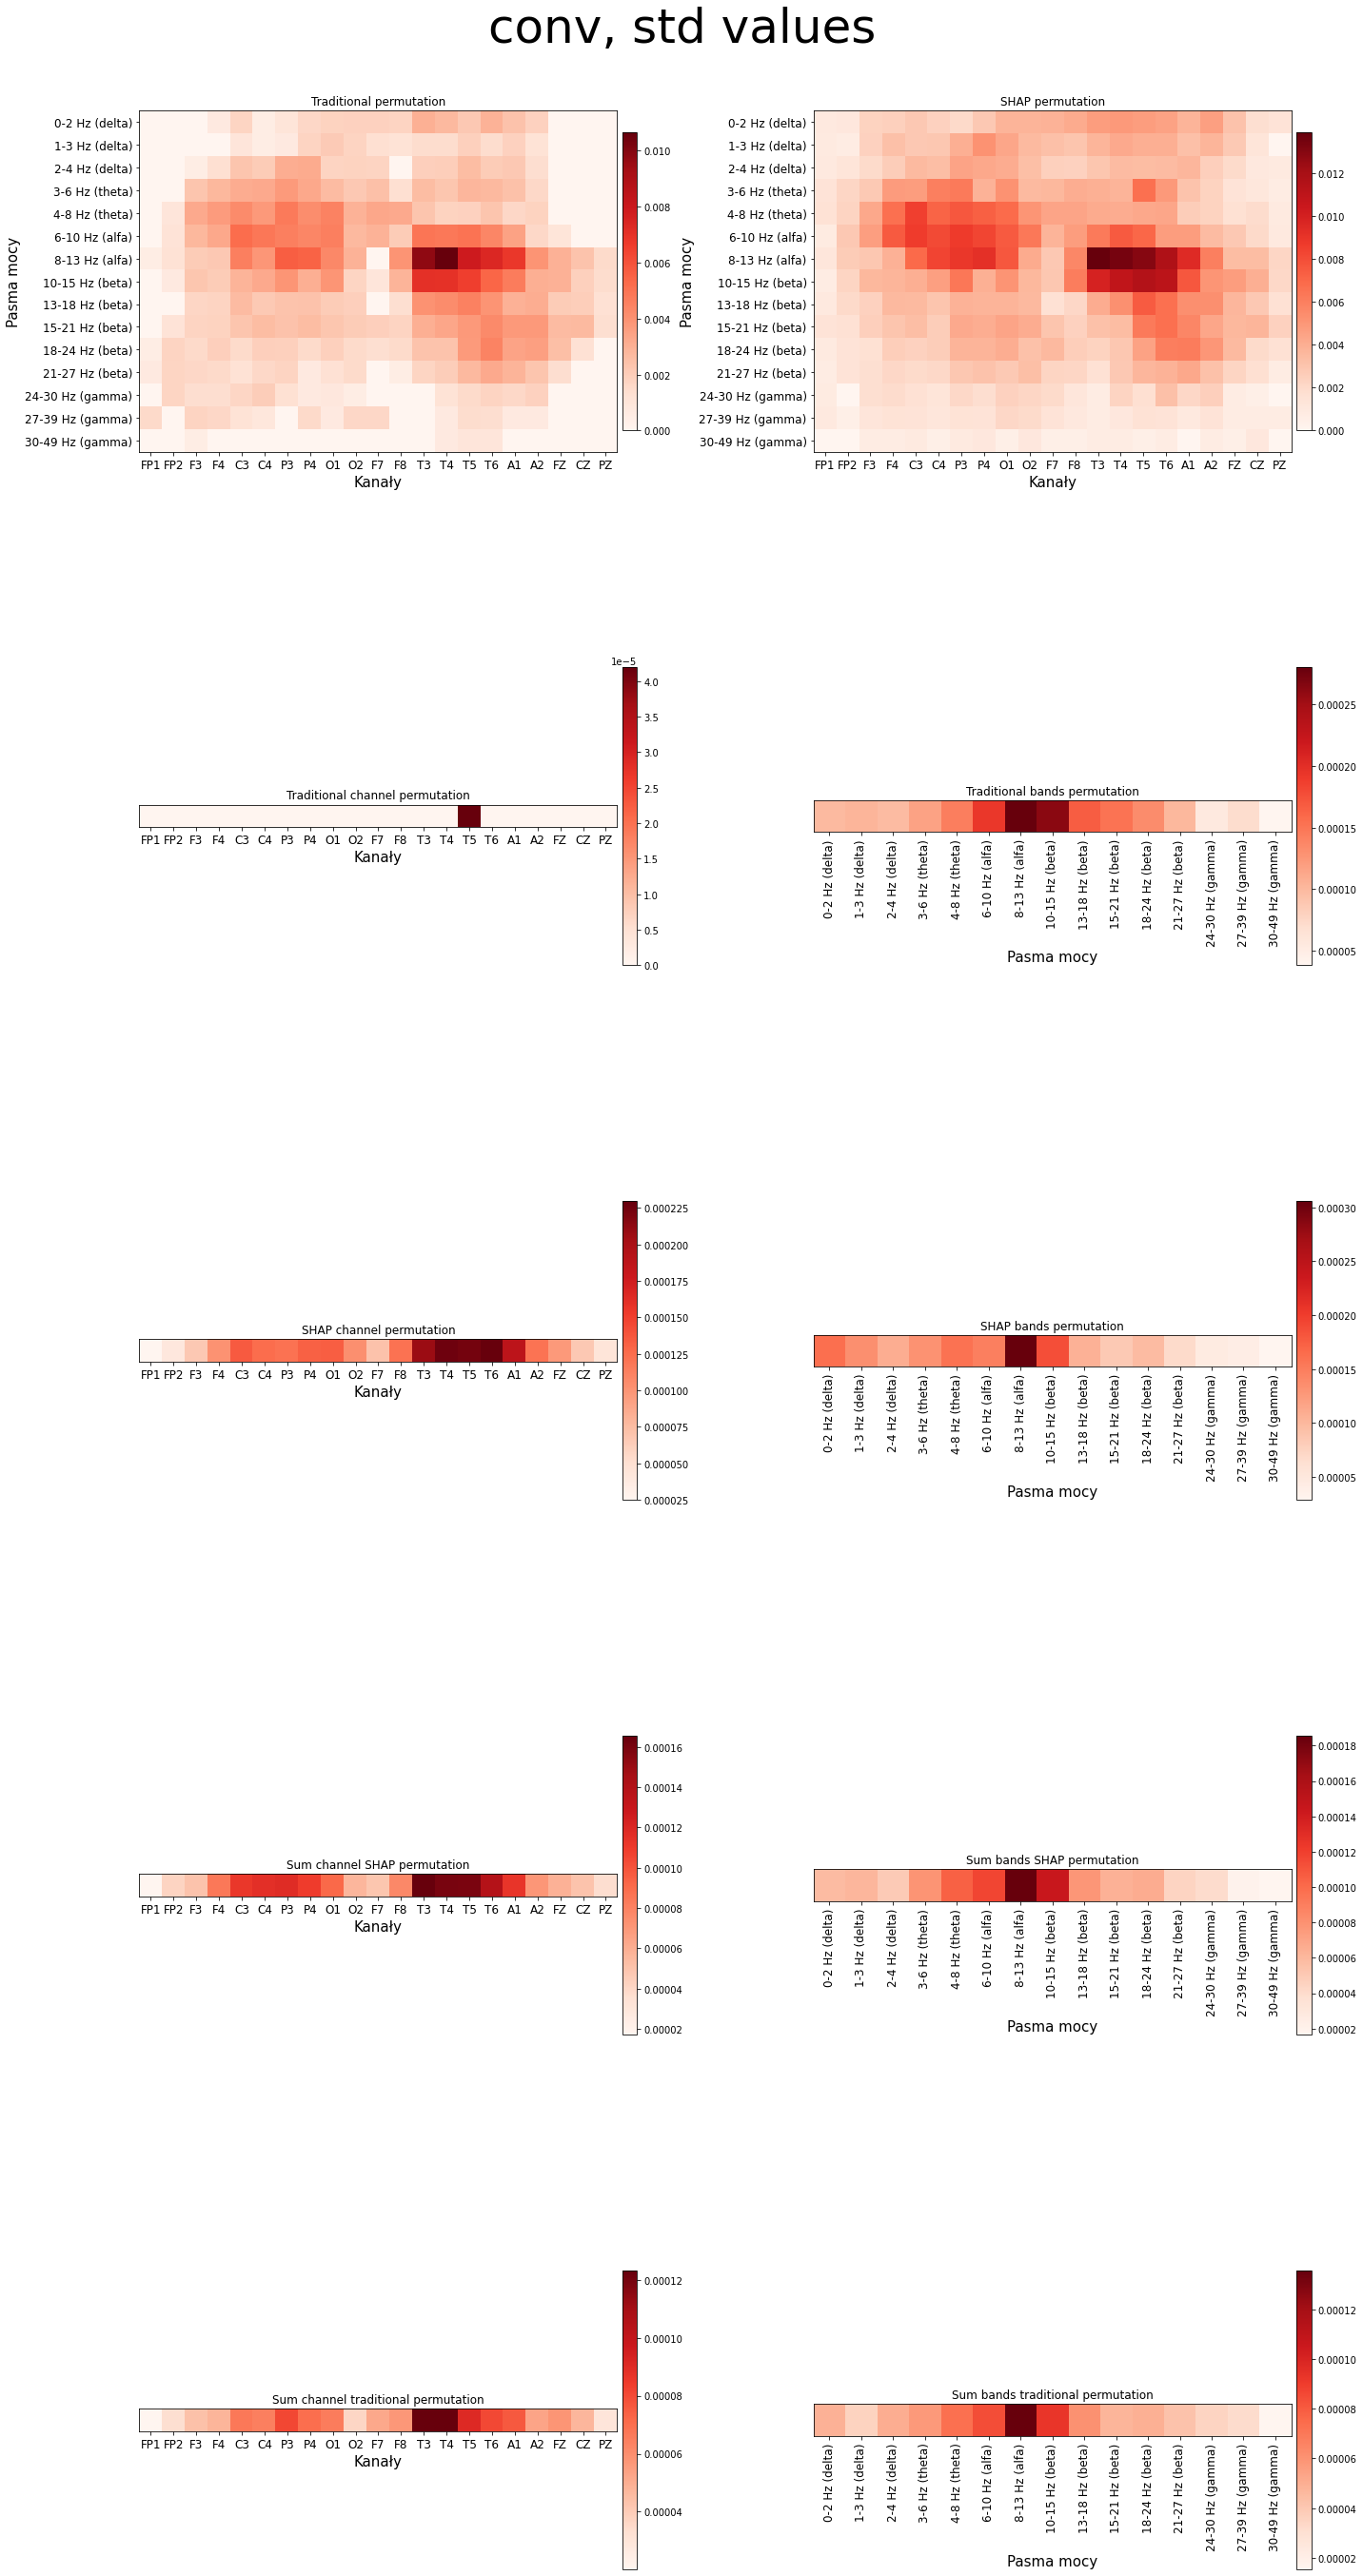

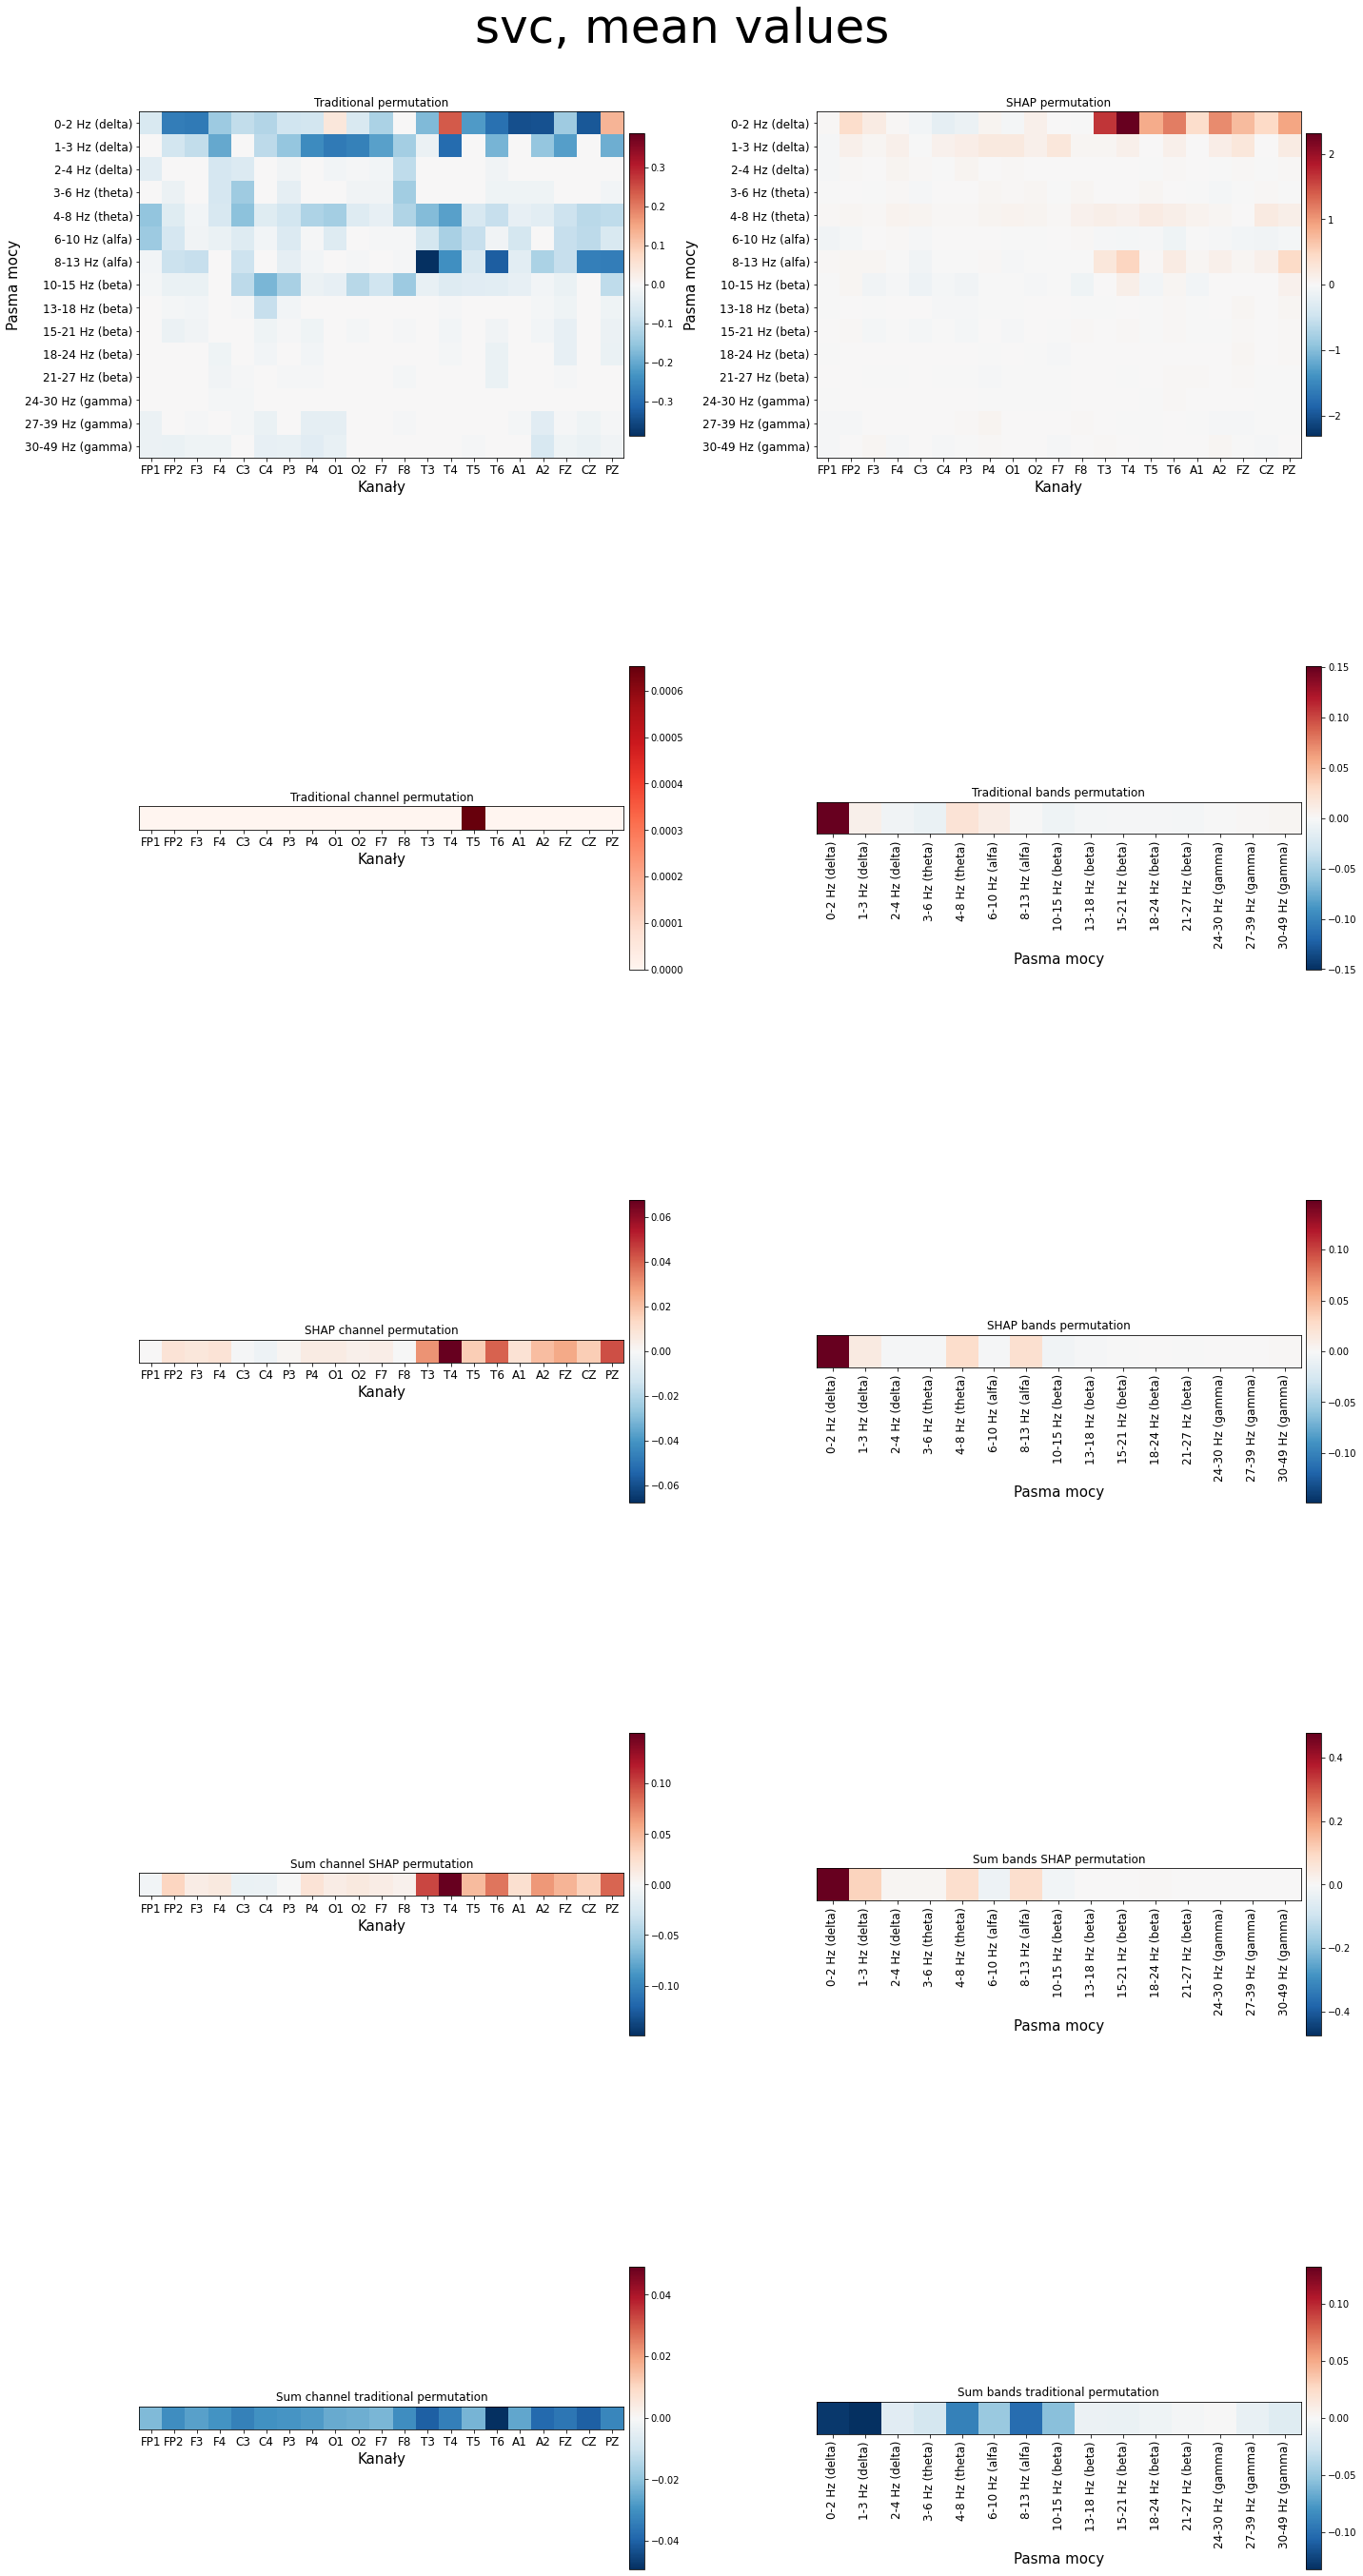

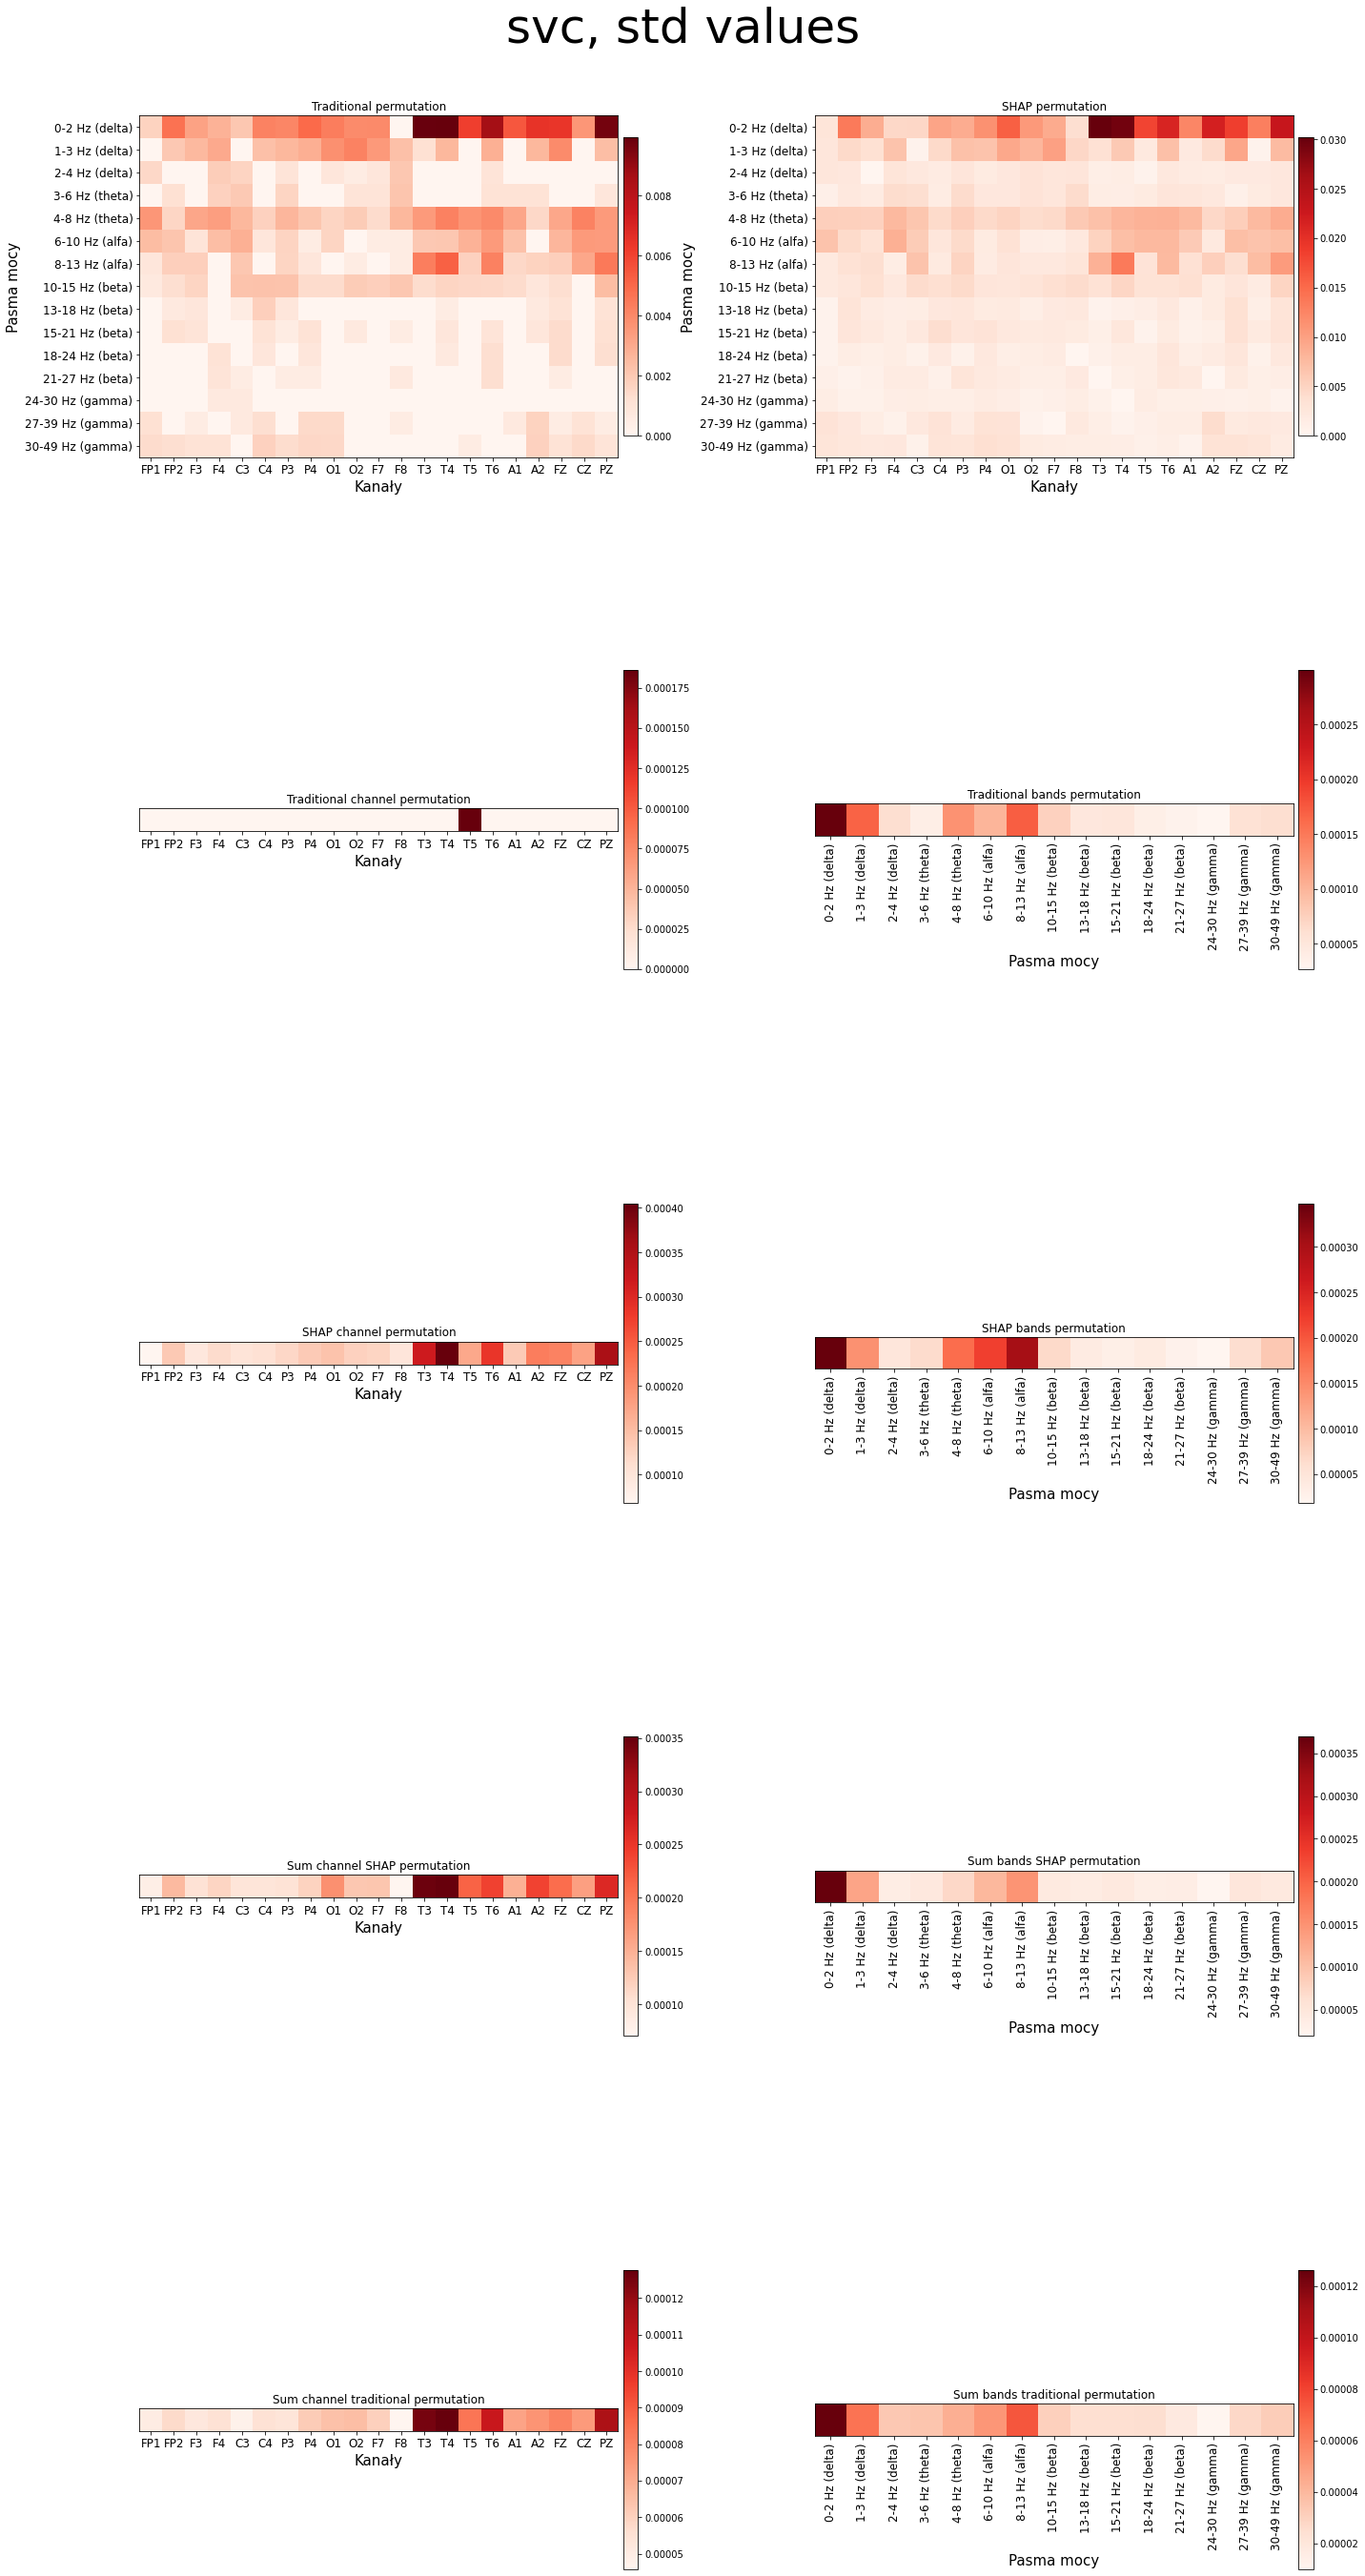

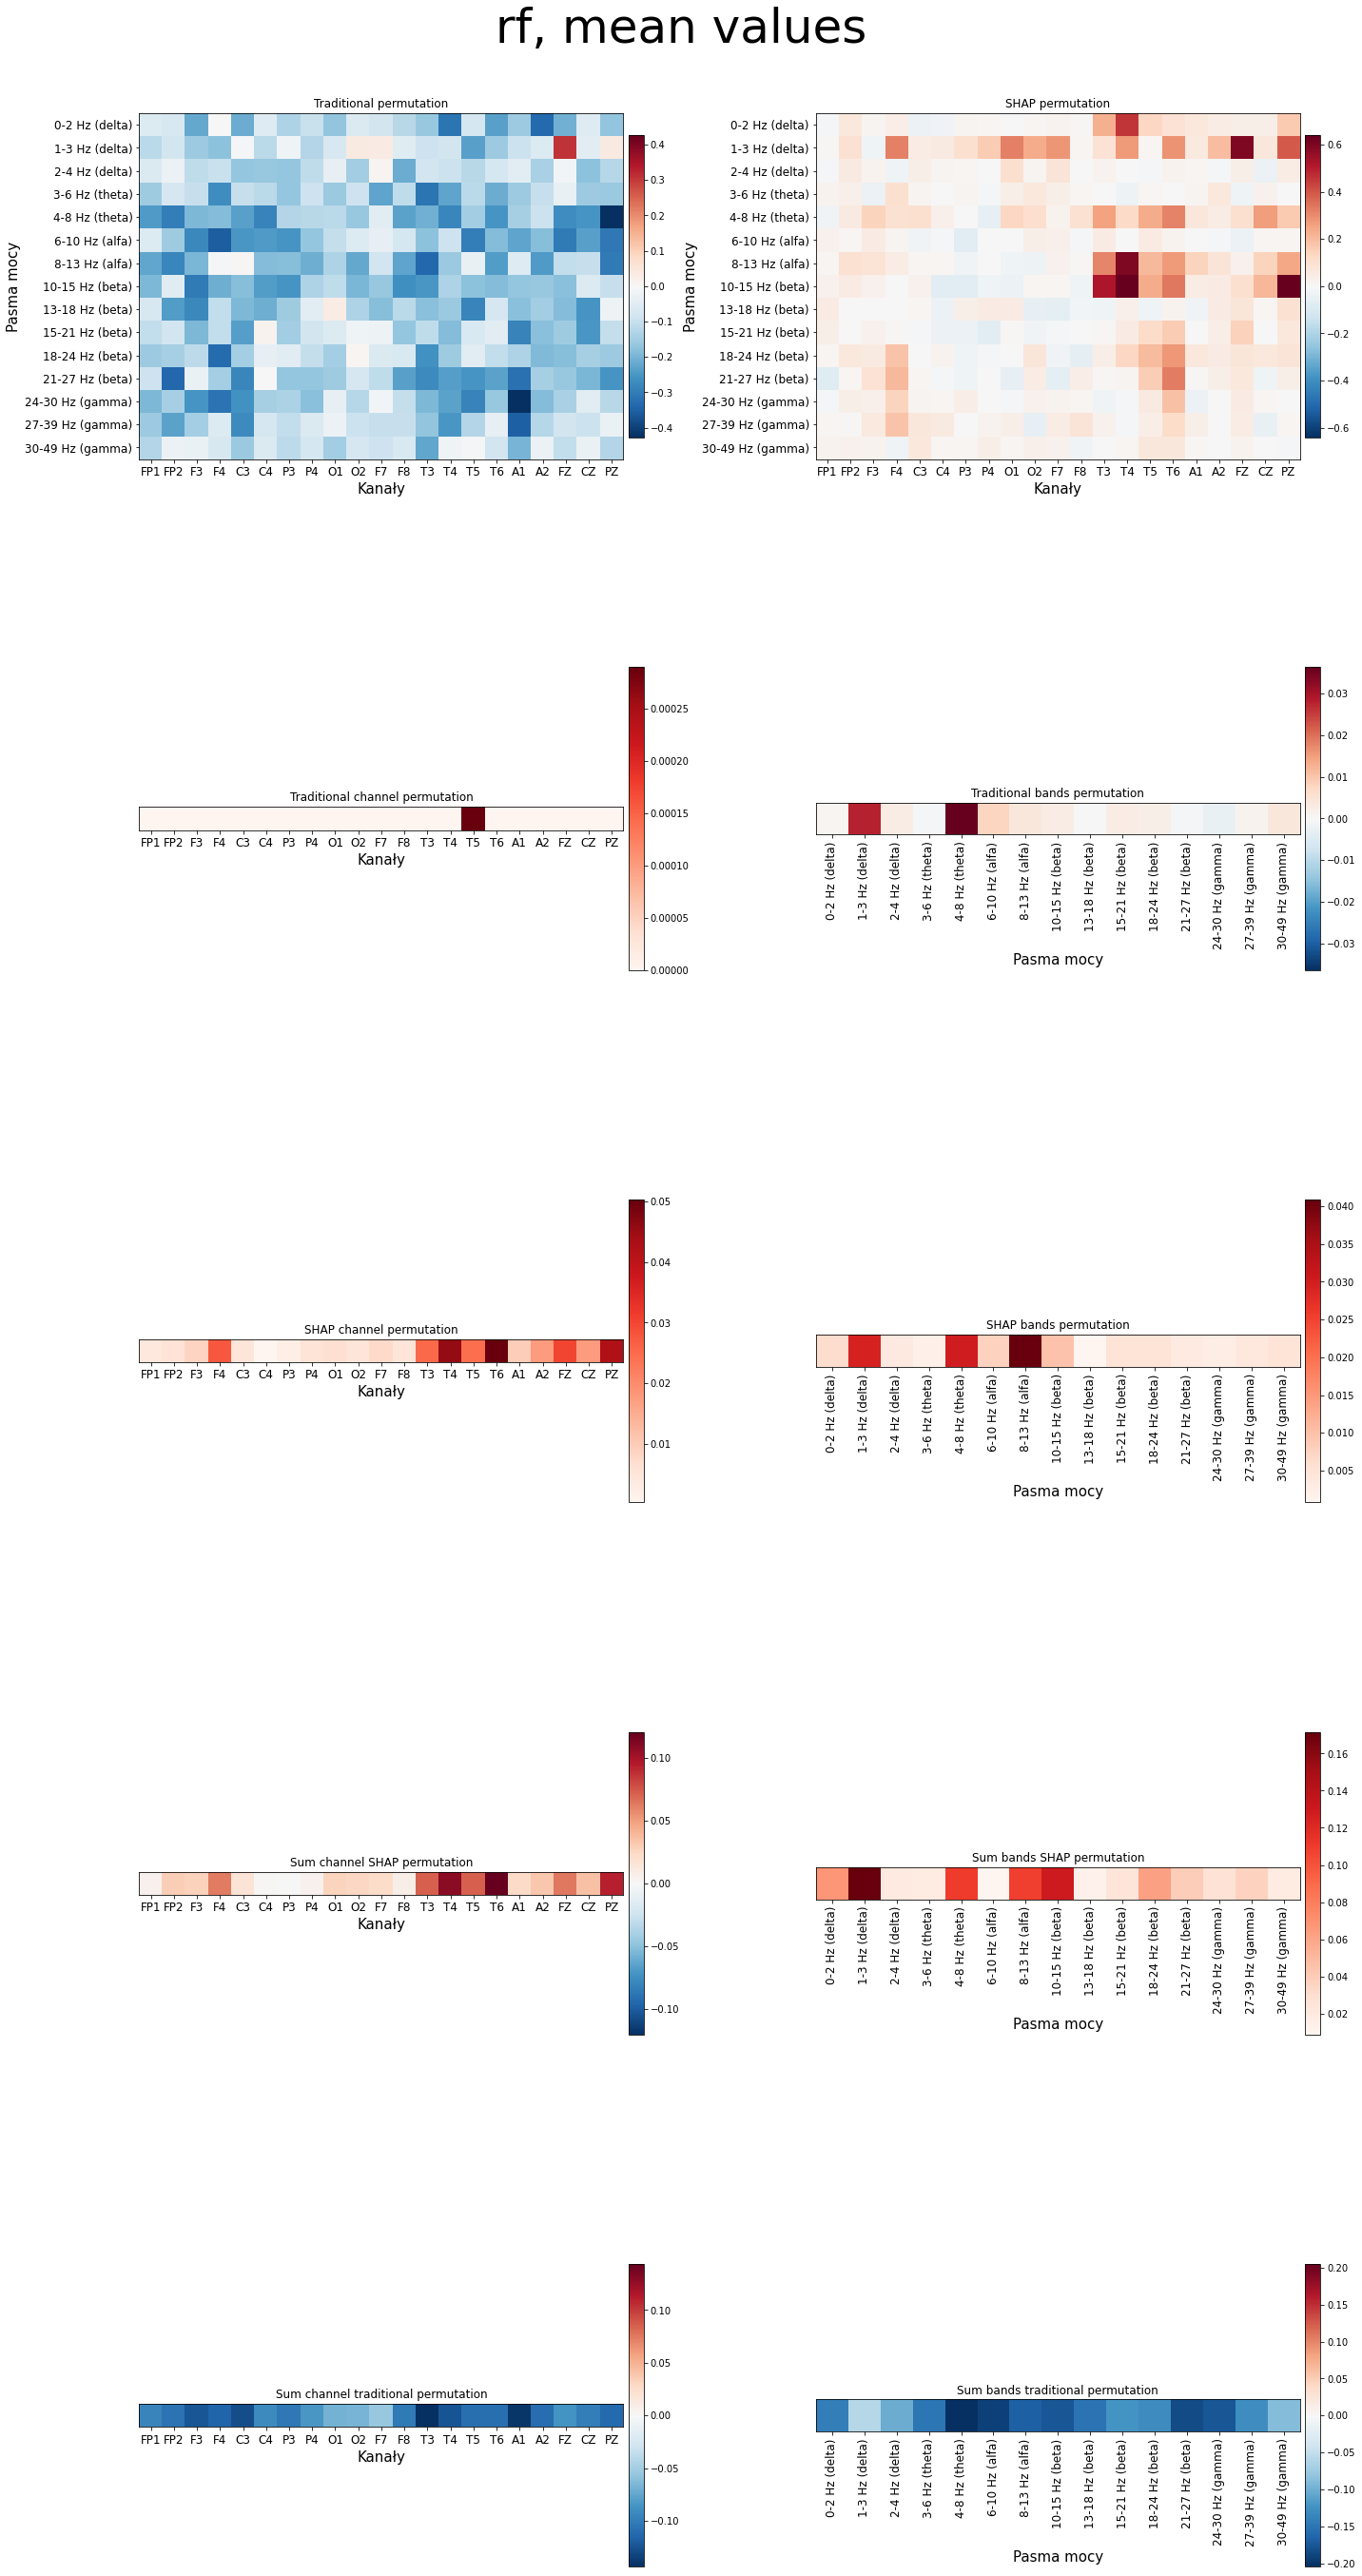

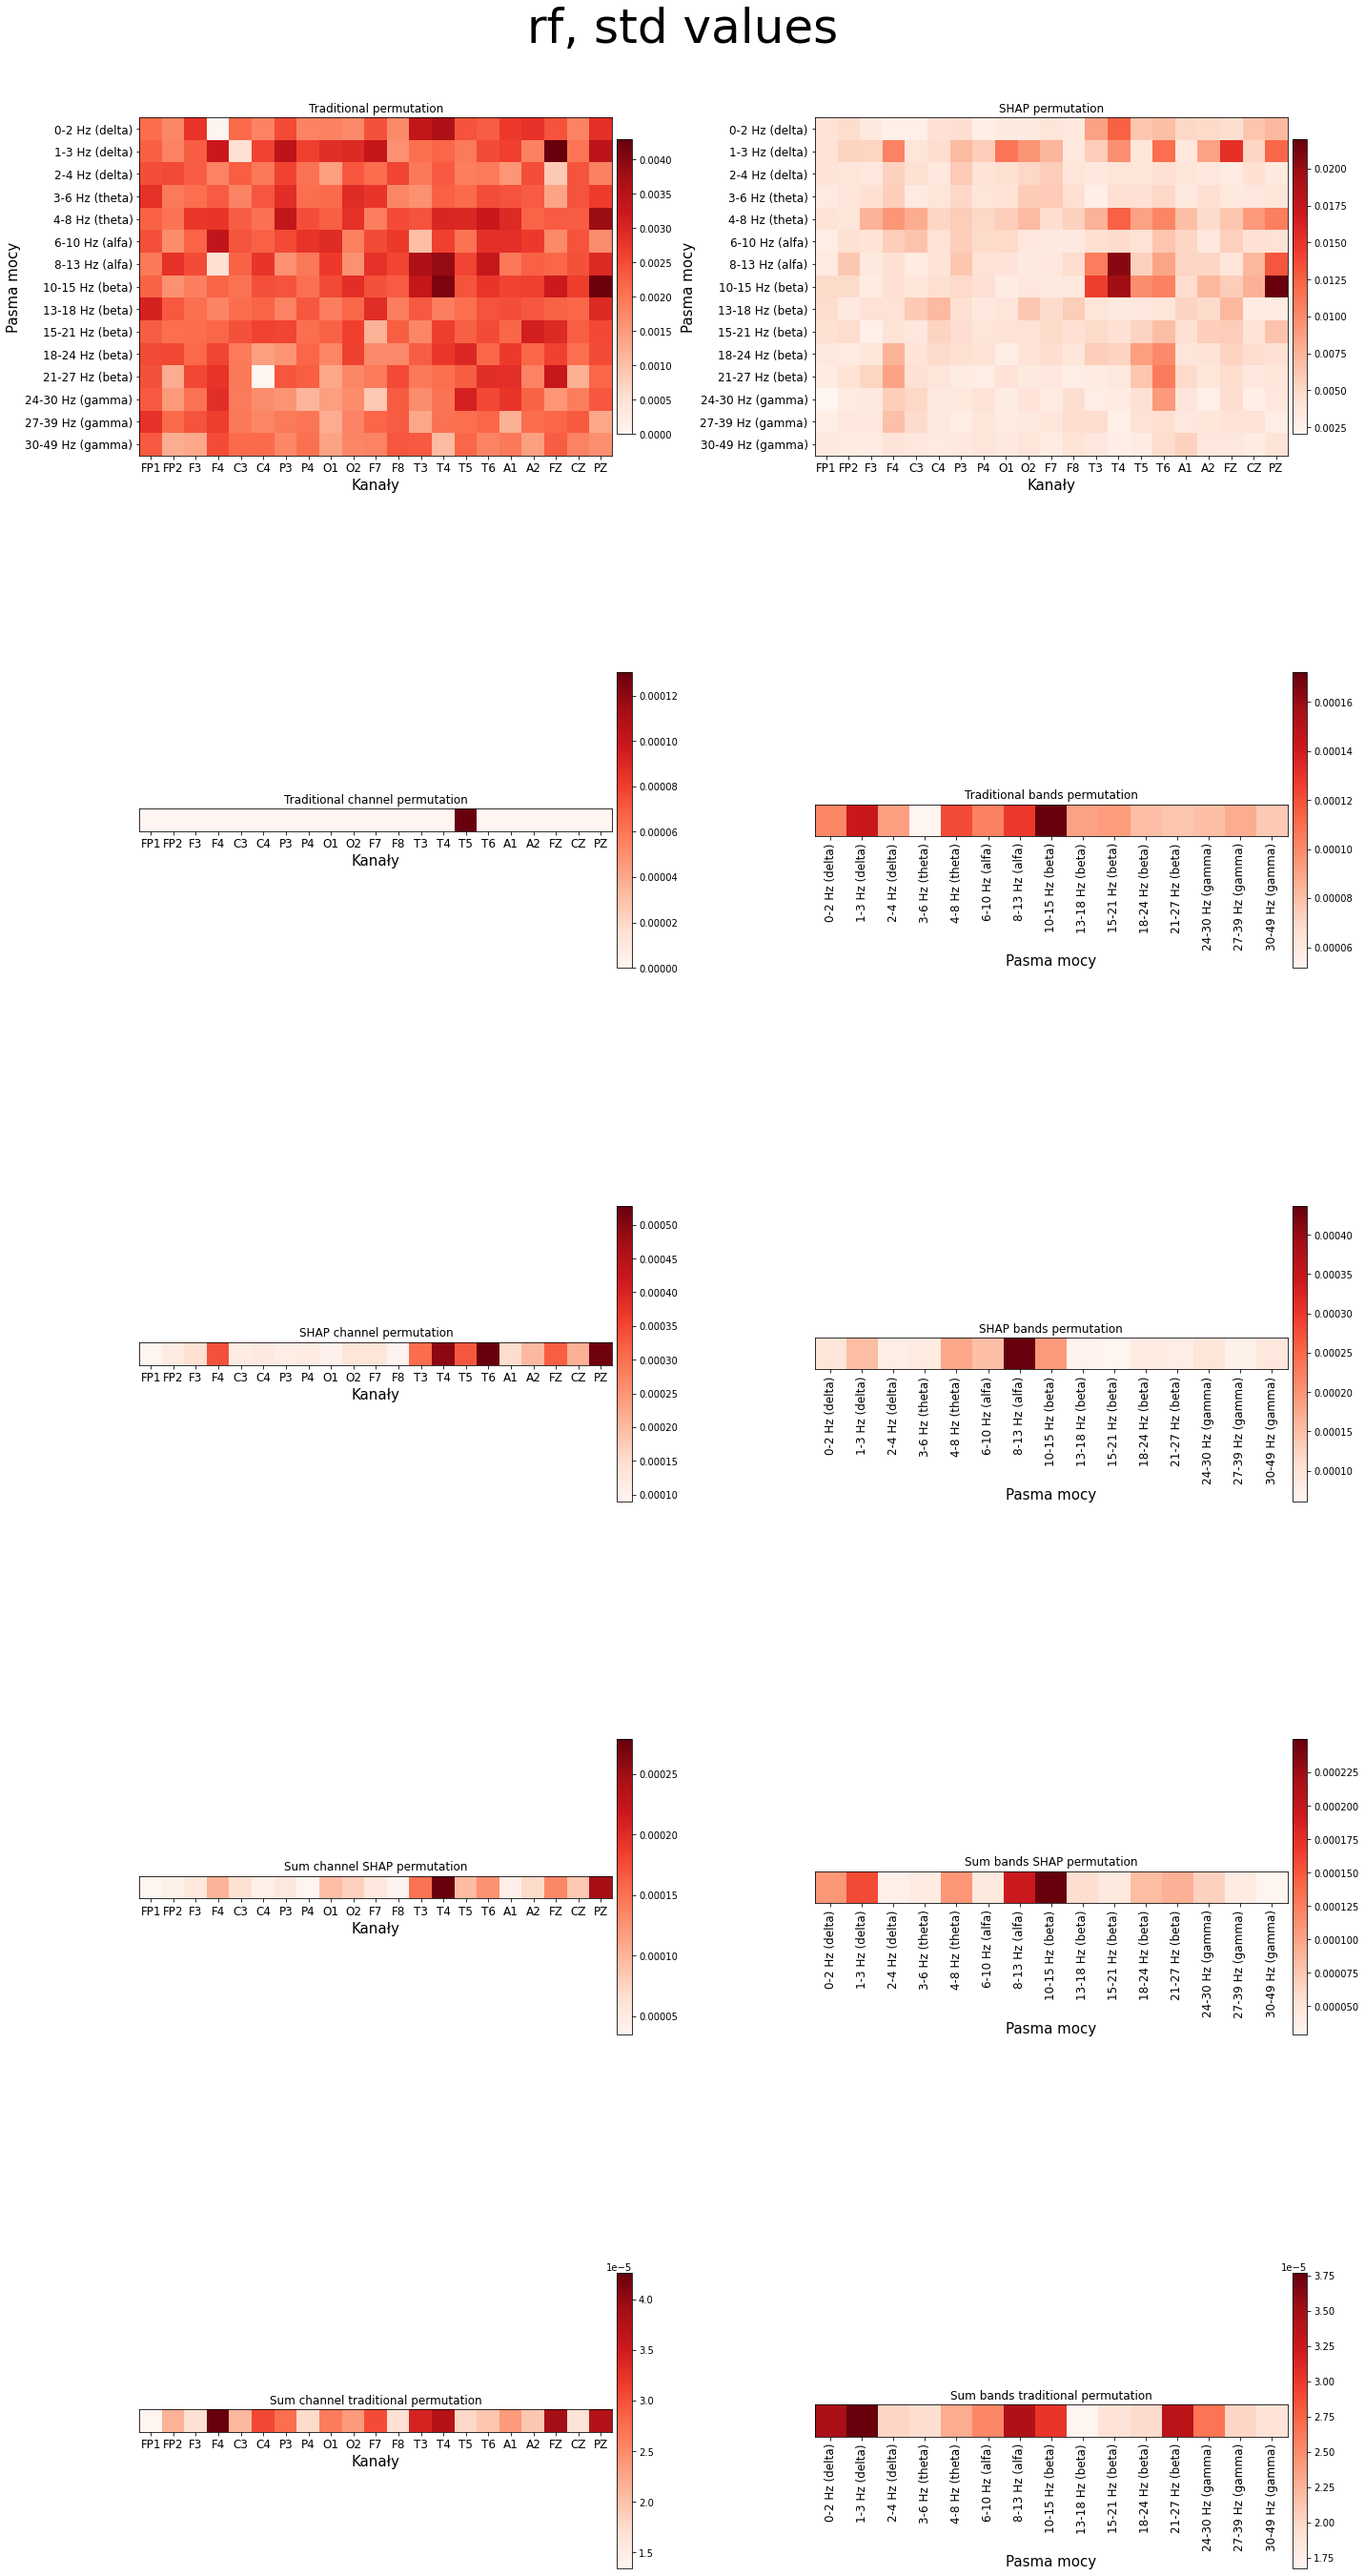

In [97]:
for model_name in ['conv', 'svc', 'rf']:
    for val, fun in {'mean': np.sum, 'std': np.std}.items():
        plot_subplot(model_name, val, fun)